Vocab size: 4762


5300it [00:00, 11350.27it/s]


Epoch 1: Train Loss = 1.361, Train Acc = 33.52%, Val Loss = 1.354, Val Acc = 33.77%, Val Precision = 0.3377, Val Recall = 0.3377, Val F1 = 0.3377
Epoch 2: Train Loss = 1.346, Train Acc = 35.09%, Val Loss = 1.354, Val Acc = 33.68%, Val Precision = 0.3368, Val Recall = 0.3368, Val F1 = 0.3368
Epoch 3: Train Loss = 1.333, Train Acc = 35.97%, Val Loss = 1.373, Val Acc = 33.21%, Val Precision = 0.3321, Val Recall = 0.3321, Val F1 = 0.3321
Epoch 4: Train Loss = 1.048, Train Acc = 55.41%, Val Loss = 1.031, Val Acc = 53.49%, Val Precision = 0.5349, Val Recall = 0.5349, Val F1 = 0.5349
Epoch 5: Train Loss = 0.952, Train Acc = 58.52%, Val Loss = 1.032, Val Acc = 53.58%, Val Precision = 0.5358, Val Recall = 0.5358, Val F1 = 0.5358
Epoch 6: Train Loss = 0.890, Train Acc = 60.78%, Val Loss = 1.032, Val Acc = 57.92%, Val Precision = 0.5792, Val Recall = 0.5792, Val F1 = 0.5792
Epoch 7: Train Loss = 0.847, Train Acc = 64.39%, Val Loss = 1.003, Val Acc = 59.53%, Val Precision = 0.5953, Val Recall = 0.

/tmp/ipykernel_8814/2967464685.py:220: UserWarning: Glyph 28287 (\N{CJK UNIFIED IDEOGRAPH-6E7F}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/2967464685.py:220: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/2967464685.py:220: UserWarning: Glyph 34164 (\N{CJK UNIFIED IDEOGRAPH-8574}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/2967464685.py:220: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/2967464685.py:220: UserWarning: Glyph 20860 (\N{CJK UNIFIED IDEOGRAPH-517C}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/2967464685.py:220: UserWarning: Glyph 33086 (\N{CJK UNIFIED IDEOGRAPH-813E}) mis

Test Loss: 1.009, Test Acc: 61.13%
Training complete! Time taken: 0:07:27


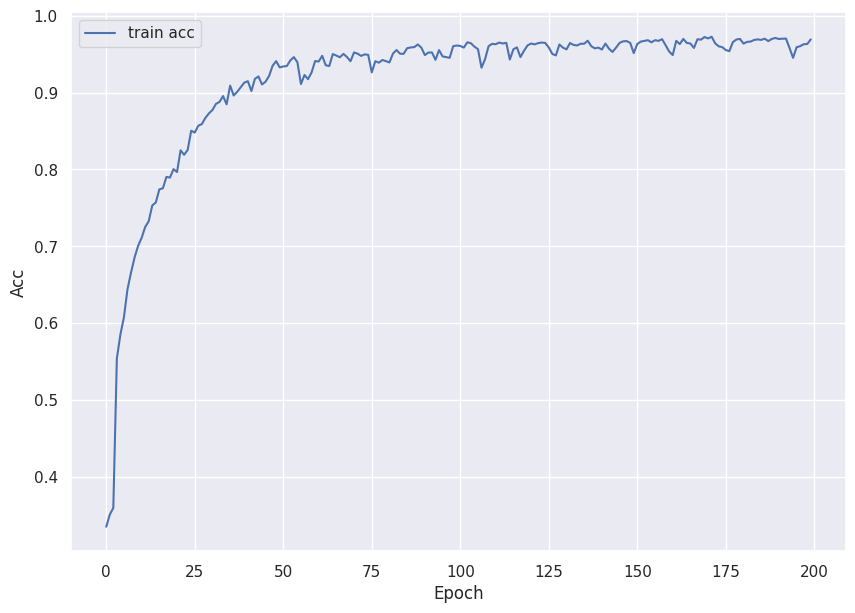

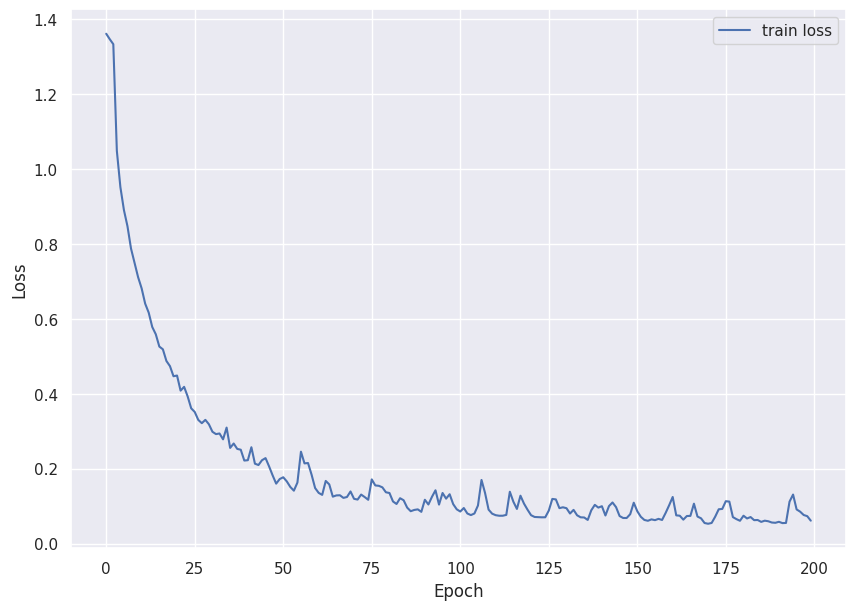

/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28287 (\N{CJK UNIFIED IDEOGRAPH-6E7F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 34164 (\N{CJK UNIFIED IDEOGRAPH-8574}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20860 (\N{CJK UNIFIE

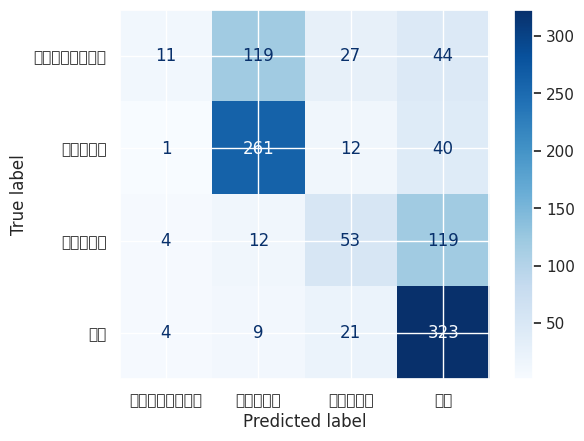

In [3]:
# -*- coding: utf-8 -*-
import numpy as np
import pickle as pkl
from tqdm import tqdm
from datetime import timedelta
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
import torch
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
from sklearn.metrics import precision_recall_fscore_support

# 超参数设置
data_path = './data0924.txt'              # 数据集
vocab_path = './vocab.pkl'                 # 词表
save_path = './lstm.ckpt'                   # 模型训练结果
embedding_pretrained = torch.tensor(
    np.load('./embedding_Tencent.npz')["embeddings"].astype('float32')
)  # 预训练词向量
embed = embedding_pretrained.size(1)        # 词向量维度
dropout = 0.5                               # 随机丢弃
num_classes = 4                             # 类别数
num_epochs = 200                            # epoch数
batch_size = 16                             # mini-batch大小
pad_size = 512                              # 每句话处理成的长度(短填长切)
learning_rate = 1e-3                        # 学习率
hidden_size = 128                           # lstm隐藏层
num_layers = 2                              # lstm层数
MAX_VOCAB_SIZE = 10000                      # 词表长度限制
UNK, PAD = '<UNK>', '<PAD>'                 # 未知字，padding符号

# 记录指标
metrics_1 = {
    "precision": [],
    "f1_score": [],
    "recall": []
}

def get_data():
    tokenizer = lambda x: [y for y in x]  # 字级别
    vocab = pkl.load(open(vocab_path, 'rb'))
    print(f"Vocab size: {len(vocab)}")
    train, dev, test = load_dataset(data_path, pad_size, tokenizer, vocab)
    return vocab, train, dev, test

def load_dataset(path, pad_size, tokenizer, vocab):
    contents = []
    with open(path, 'r', encoding='gbk') as f:  # 确保编码正确
        for line in tqdm(f):
            lin = line.strip()
            if not lin:
                continue
            label, content = lin.split('	####	')
            words_line = []
            token = tokenizer(content)
            seq_len = len(token)
            if pad_size:
                if len(token) < pad_size:
                    token.extend([vocab.get(PAD)] * (pad_size - len(token)))
                else:
                    token = token[:pad_size]
                    seq_len = pad_size
            for word in token:
                words_line.append(vocab.get(word, vocab.get(UNK)))
            contents.append((words_line, int(label)))

    train, X_t = train_test_split(contents, test_size=0.4, random_state=42)
    dev, test = train_test_split(X_t, test_size=0.5, random_state=42)
    return train, dev, test

class TextDataset(Dataset):
    def __init__(self, data):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.x = torch.LongTensor([x[0] for x in data]).to(self.device)
        self.y = torch.LongTensor([x[1] for x in data]).to(self.device)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

def get_time_dif(start_time):
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_pretrained, freeze=False)
        self.lstm = nn.LSTM(embed, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out = self.embedding(x)
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        return out

def init_network(model, method='xavier', exclude='embedding'):
    for name, w in model.named_parameters():
        if exclude not in name:
            if 'weight' in name:
                nn.init.xavier_normal_(w)
            elif 'bias' in name:
                nn.init.constant_(w, 0)

def plot_acc(train_acc):
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 7))
    plt.plot(list(range(len(train_acc))), train_acc, label='train acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend(loc='best')
    plt.savefig('./acc.png', dpi=400)

def plot_loss(train_loss):
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 7))
    plt.plot(list(range(len(train_loss))), train_loss, label='train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.savefig('./loss.png', dpi=400)

def train(model, dataloaders):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    dev_best_loss = float('inf')
    
    plot_train_acc = []
    plot_train_loss = []
    
    for i in range(num_epochs):
        model.train()
        step = 0
        train_lossi = 0
        train_acci = 0
        
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            step += 1
            true = labels.data.cpu()
            predic = torch.max(outputs.data, 1)[1].cpu()
            train_lossi += loss.item()
            train_acci += metrics.accuracy_score(true, predic)
        
        dev_acc, dev_loss, dev_precision, dev_recall, dev_f1 = dev_eval(model, dataloaders['dev'], loss_function)

        if dev_loss < dev_best_loss:
            dev_best_loss = dev_loss
            torch.save(model.state_dict(), save_path)
        
        train_acc = train_acci / step
        train_loss = train_lossi / step
        plot_train_acc.append(train_acc)
        plot_train_loss.append(train_loss)
        
        print(f"Epoch {i+1}: Train Loss = {train_loss:.3f}, Train Acc = {train_acc:.2%}, "
              f"Val Loss = {dev_loss:.3f}, Val Acc = {dev_acc:.2%}, "
              f"Val Precision = {dev_precision:.4f}, Val Recall = {dev_recall:.4f}, Val F1 = {dev_f1:.4f}")

    plot_acc(plot_train_acc)
    plot_loss(plot_train_loss)
    
    model.load_state_dict(torch.load(save_path))
    model.eval()
    test_acc, test_loss, _, _, _ = dev_eval(model, dataloaders['test'], loss_function, Result_test=True)
    print('=================' * 8)
    print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2%}')

def dev_eval(model, data, loss_function, Result_test=False):
    model.eval()
    loss_total = 0
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)

    with torch.no_grad():
        for texts, labels in data:
            outputs = model(texts)
            loss = loss_function(outputs, labels)
            loss_total += loss.item()
            labels = labels.data.cpu().numpy()
            predic = torch.max(outputs.data, 1)[1].cpu().numpy()
            labels_all = np.append(labels_all, labels)
            predict_all = np.append(predict_all, predic)

    acc = metrics.accuracy_score(labels_all, predict_all)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_all, predict_all, average='micro')

    if Result_test:
        result_test(labels_all, predict_all)
    
    return acc, loss_total / len(data), precision, recall, f1

def result_test(real, pred):
    cv_conf = confusion_matrix(real, pred)
    acc = accuracy_score(real, pred)
    precision = precision_score(real, pred, average='micro')
    recall = recall_score(real, pred, average='micro')
    f1 = f1_score(real, pred, average='micro')
    
    print(f'Test: Acc = {acc:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}')
    labels = ['湿热蕴结兼脾虚证', '湿热蕴结证', '脾虚气滞证', '其他']
    disp = ConfusionMatrixDisplay(confusion_matrix=cv_conf, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.savefig('./confusion_matrix.png', dpi=400)

if __name__ == '__main__':
    start_time = time.time()
    vocab, train_data, dev_data, test_data = get_data()
    train_data = TextDataset(train_data)
    dev_data = TextDataset(dev_data)
    test_data = TextDataset(test_data)

    dataloaders = {
        'train': DataLoader(train_data, batch_size=batch_size, shuffle=True),
        'dev': DataLoader(dev_data, batch_size=batch_size),
        'test': DataLoader(test_data, batch_size=batch_size),
    }
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = Model().to(device)
    init_network(model)

    train(model, dataloaders)
    end_time = get_time_dif(start_time)
    print("Training complete! Time taken:", end_time)


In [4]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# 创建一个 PDF 文件来保存结果
pdf_path = './training_results.pdf'

def save_results_to_pdf(train_losses, train_accuracies, val_losses, val_accuracies, val_precisions, val_recalls, val_f1s):
    with PdfPages(pdf_path) as pdf:
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.title('Loss over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        pdf.savefig()  # 保存当前图形到 PDF
        plt.close()

        plt.figure(figsize=(10, 6))
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Val Accuracy')
        plt.title('Accuracy over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        pdf.savefig()
        plt.close()

        plt.figure(figsize=(10, 6))
        plt.plot(val_precisions, label='Val Precision')
        plt.plot(val_recalls, label='Val Recall')
        plt.plot(val_f1s, label='Val F1 Score')
        plt.title('Validation Metrics over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Scores')
        plt.legend()
        pdf.savefig()
        plt.close()

# 在 train 函数中记录这些指标
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

for i in range(num_epochs):
    # ... (原有的训练代码)
    
    # 在每个 epoch 结束时，记录指标
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(dev_loss)
    val_accuracies.append(dev_acc)
    val_precisions.append(dev_precision)
    val_recalls.append(dev_recall)
    val_f1s.append(dev_f1)

# 训练完成后保存结果到 PDF
save_results_to_pdf(train_losses, train_accuracies, val_losses, val_accuracies, val_precisions, val_recalls, val_f1s)

print(f"Results saved to {pdf_path}")


NameError: name 'train_loss' is not defined

In [ ]:
import pickle



# 保存为 Pickle 文件
with open("metrics.pkl", "wb") as pickle_file:
    pickle.dump(metrics_1, pickle_file)
print(metrics_1)
print("字典已保存为 metrics.pkl")

In [ ]:
import pickle

# 使用二进制模式 ('rb') 打开文件
with open('metrics.pkl', 'rb') as file:
    metrics = pickle.load(file)

# 打印或处理读取的数据
print(metrics)

In [ ]:
import matplotlib.pyplot as plt

# 绘制多个曲线图
plt.figure(figsize=(12, 8))  # 设置图形大小

# 为每个索引绘制曲线
print(metrics.get('precision'))
for index, values in metrics.items():
    plt.plot(values, label=index, marker='o', linestyle='-')

# 添加图例、标题和标签
plt.xlabel('epoches ')
plt.ylabel('Values')
plt.title('Line Chart for Three Indexes')
plt.legend(loc='best')
plt.grid(True)  # 添加网格线

# 显示图形
plt.show()


In [2]:
pip install lime

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=08b59a58f710e89bab13323f99f05201029ede90b326529229a8491a81ed3669
  Stored in directory: /home/featurize/.cache/pip/wheels/0b/8a/67/19e8d61cb1165250d82edc202d7147fb1cf2d2a00af8d5c329
Successfully built lime
Note: you may need to restart the kernel to use updated packages.


Vocab size: 4762


5300it [00:00, 10668.48it/s]


Epoch 1: Train Loss = 1.359, Train Acc = 33.30%, Val Loss = 1.352, Val Acc = 32.64%, Val Precision = 0.3264, Val Recall = 0.3264, Val F1 = 0.3264
Epoch 2: Train Loss = 1.349, Train Acc = 34.55%, Val Loss = 1.356, Val Acc = 33.11%, Val Precision = 0.3311, Val Recall = 0.3311, Val F1 = 0.3311
Epoch 3: Train Loss = 1.314, Train Acc = 39.57%, Val Loss = 1.308, Val Acc = 52.26%, Val Precision = 0.5226, Val Recall = 0.5226, Val F1 = 0.5226
Epoch 4: Train Loss = 1.088, Train Acc = 53.55%, Val Loss = 1.052, Val Acc = 53.58%, Val Precision = 0.5358, Val Recall = 0.5358, Val F1 = 0.5358
Epoch 5: Train Loss = 0.979, Train Acc = 59.15%, Val Loss = 1.061, Val Acc = 53.30%, Val Precision = 0.5330, Val Recall = 0.5330, Val F1 = 0.5330
Epoch 6: Train Loss = 0.926, Train Acc = 60.50%, Val Loss = 1.078, Val Acc = 54.25%, Val Precision = 0.5425, Val Recall = 0.5425, Val F1 = 0.5425
Epoch 7: Train Loss = 0.929, Train Acc = 60.26%, Val Loss = 1.126, Val Acc = 54.15%, Val Precision = 0.5415, Val Recall = 0.

/tmp/ipykernel_8814/3131093278.py:267: UserWarning: Glyph 28287 (\N{CJK UNIFIED IDEOGRAPH-6E7F}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/3131093278.py:267: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/3131093278.py:267: UserWarning: Glyph 34164 (\N{CJK UNIFIED IDEOGRAPH-8574}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/3131093278.py:267: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/3131093278.py:267: UserWarning: Glyph 20860 (\N{CJK UNIFIED IDEOGRAPH-517C}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/3131093278.py:267: UserWarning: Glyph 33086 (\N{CJK UNIFIED IDEOGRAPH-813E}) mis

Test Loss: 1.039, Test Acc: 60.85%


ModuleNotFoundError: No module named 'openpyxl'

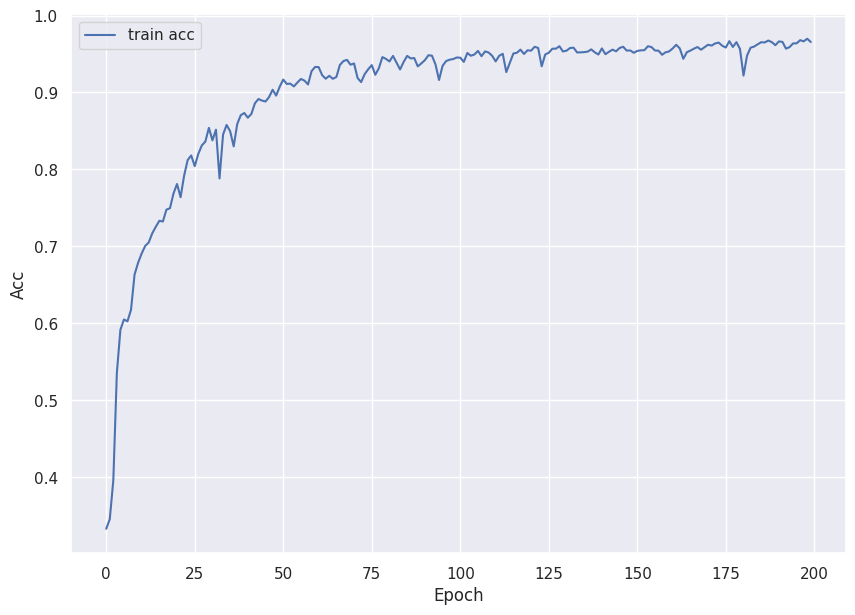

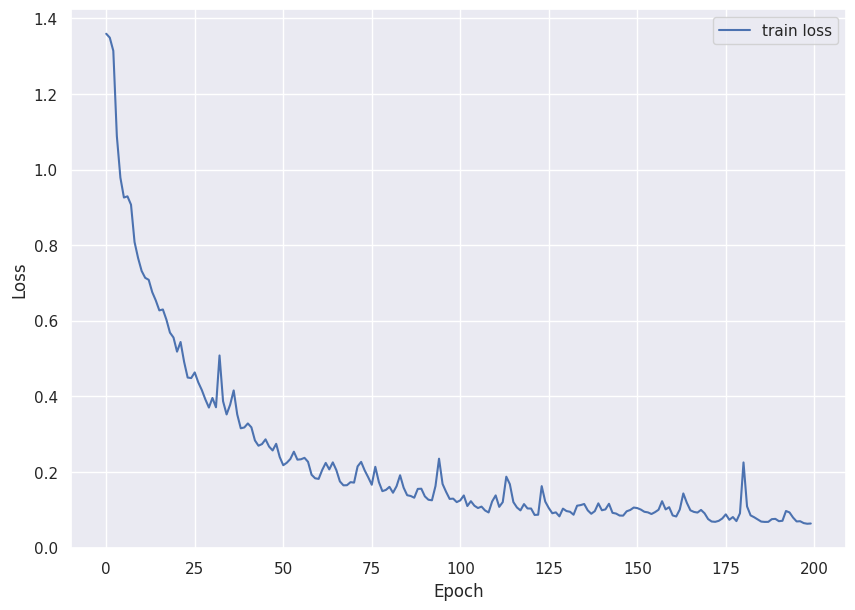

/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28287 (\N{CJK UNIFIED IDEOGRAPH-6E7F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 34164 (\N{CJK UNIFIED IDEOGRAPH-8574}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20860 (\N{CJK UNIFIE

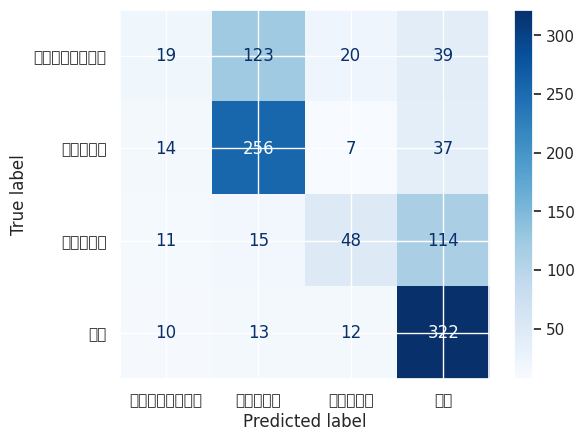

In [5]:
# -*- coding: utf-8 -*-
import numpy as np
import pickle as pkl
from tqdm import tqdm
from datetime import timedelta
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
import torch
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

# 超参数设置
data_path = './data0924.txt'              # 数据集
vocab_path = './vocab.pkl'                 # 词表
save_path = './lstm.ckpt'                   # 模型训练结果
embedding_pretrained = torch.tensor(
    np.load('./embedding_Tencent.npz')["embeddings"].astype('float32')
)  # 预训练词向量
embed = embedding_pretrained.size(1)        # 词向量维度
dropout = 0.5                               # 随机丢弃
num_classes = 4                             # 类别数
num_epochs = 200                            # epoch数
batch_size = 16                             # mini-batch大小
pad_size = 512                              # 每句话处理成的长度(短填长切)
learning_rate = 1e-3                        # 学习率
hidden_size = 128                           # lstm隐藏层
num_layers = 2                              # lstm层数
MAX_VOCAB_SIZE = 10000                      # 词表长度限制
UNK, PAD = '<UNK>', '<PAD>'                 # 未知字，padding符号

# 记录指标
metrics_1 = {
    "precision": [],
    "f1_score": [],
    "recall": []
}

def get_data():
    tokenizer = lambda x: [y for y in x]  # 字级别
    vocab = pkl.load(open(vocab_path, 'rb'))
    print(f"Vocab size: {len(vocab)}")
    train, dev, test = load_dataset(data_path, pad_size, tokenizer, vocab)
    return vocab, train, dev, test

def load_dataset(path, pad_size, tokenizer, vocab):
    contents = []
    with open(path, 'r', encoding='gbk') as f:  # 确保编码正确
        for line in tqdm(f):
            lin = line.strip()
            if not lin:
                continue
            label, content = lin.split('	####	')
            words_line = []
            token = tokenizer(content)
            seq_len = len(token)
            if pad_size:
                if len(token) < pad_size:
                    token.extend([vocab.get(PAD)] * (pad_size - len(token)))
                else:
                    token = token[:pad_size]
                    seq_len = pad_size
            for word in token:
                words_line.append(vocab.get(word, vocab.get(UNK)))
            contents.append((words_line, int(label)))

    train, X_t = train_test_split(contents, test_size=0.4, random_state=42)
    dev, test = train_test_split(X_t, test_size=0.5, random_state=42)
    return train, dev, test

class TextDataset(Dataset):
    def __init__(self, data):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.x = torch.LongTensor([x[0] for x in data]).to(self.device)
        self.y = torch.LongTensor([x[1] for x in data]).to(self.device)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

def get_time_dif(start_time):
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_pretrained, freeze=False)
        self.lstm = nn.LSTM(embed, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out = self.embedding(x)
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        return out

def init_network(model, method='xavier', exclude='embedding'):
    for name, w in model.named_parameters():
        if exclude not in name:
            if 'weight' in name:
                nn.init.xavier_normal_(w)
            elif 'bias' in name:
                nn.init.constant_(w, 0)

def plot_acc(train_acc):
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 7))
    plt.plot(list(range(len(train_acc))), train_acc, label='train acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend(loc='best')
    plt.savefig('./acc.png', dpi=400)

def plot_loss(train_loss):
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 7))
    plt.plot(list(range(len(train_loss))), train_loss, label='train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.savefig('./loss.png', dpi=400)

def save_metrics_to_pdf(metrics, filename):
    with PdfPages(filename) as pdf:
        plt.figure(figsize=(10, 5))
        plt.plot(metrics['precision'], label='Precision', marker='o', color='blue')
        plt.title('Precision Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Precision Score')
        plt.legend()
        plt.grid()
        pdf.savefig()
        plt.close()

        plt.figure(figsize=(10, 5))
        plt.plot(metrics['f1_score'], label='F1 Score', marker='s', color='green')
        plt.title('F1 Score Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid()
        pdf.savefig()
        plt.close()

        plt.figure(figsize=(10, 5))
        plt.plot(metrics['recall'], label='Recall', marker='^', color='red')
        plt.title('Recall Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Recall Score')
        plt.legend()
        plt.grid()
        pdf.savefig()
        plt.close()

def save_metrics_to_excel(metrics, filename):
    df = pd.DataFrame(metrics)
    df.to_excel(filename, index=False)

def train(model, dataloaders):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    dev_best_loss = float('inf')
    
    plot_train_acc = []
    plot_train_loss = []
    
    for i in range(num_epochs):
        model.train()
        step = 0
        train_lossi = 0
        train_acci = 0
        
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            step += 1
            true = labels.data.cpu()
            predic = torch.max(outputs.data, 1)[1].cpu()
            train_lossi += loss.item()
            train_acci += metrics.accuracy_score(true, predic)
        
        dev_acc, dev_loss, dev_precision, dev_recall, dev_f1 = dev_eval(model, dataloaders['dev'], loss_function)

        # 记录指标
        metrics_1['precision'].append(dev_precision)
        metrics_1['f1_score'].append(dev_f1)
        metrics_1['recall'].append(dev_recall)

        if dev_loss < dev_best_loss:
            dev_best_loss = dev_loss
            torch.save(model.state_dict(), save_path)
        
        train_acc = train_acci / step
        train_loss = train_lossi / step
        plot_train_acc.append(train_acc)
        plot_train_loss.append(train_loss)
        
        print(f"Epoch {i+1}: Train Loss = {train_loss:.3f}, Train Acc = {train_acc:.2%}, "
              f"Val Loss = {dev_loss:.3f}, Val Acc = {dev_acc:.2%}, "
              f"Val Precision = {dev_precision:.4f}, Val Recall = {dev_recall:.4f}, Val F1 = {dev_f1:.4f}")

    plot_acc(plot_train_acc)
    plot_loss(plot_train_loss)
    
    model.load_state_dict(torch.load(save_path))
    model.eval()
    test_acc, test_loss, _, _, _ = dev_eval(model, dataloaders['test'], loss_function, Result_test=True)
    print('=================' * 8)
    print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2%}')

    # 保存指标为 PDF 和 Excel
    save_metrics_to_pdf(metrics_1, 'metrics_report.pdf')
    save_metrics_to_excel(metrics_1, 'metrics_report.xlsx')

def dev_eval(model, data, loss_function, Result_test=False):
    model.eval()
    loss_total = 0
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)

    with torch.no_grad():
        for texts, labels in data:
            outputs = model(texts)
            loss = loss_function(outputs, labels)
            loss_total += loss.item()
            labels = labels.data.cpu().numpy()
            predic = torch.max(outputs.data, 1)[1].cpu().numpy()
            labels_all = np.append(labels_all, labels)
            predict_all = np.append(predict_all, predic)

    acc = metrics.accuracy_score(labels_all, predict_all)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_all, predict_all, average='micro')

    if Result_test:
        result_test(labels_all, predict_all)
    
    return acc, loss_total / len(data), precision, recall, f1

def result_test(real, pred):
    cv_conf = confusion_matrix(real, pred)
    acc = accuracy_score(real, pred)
    precision = precision_score(real, pred, average='micro')
    recall = recall_score(real, pred, average='micro')
    f1 = f1_score(real, pred, average='micro')
    
    print(f'Test: Acc = {acc:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}')
    labels = ['湿热蕴结兼脾虚证', '湿热蕴结证', '脾虚气滞证', '其他']
    disp = ConfusionMatrixDisplay(confusion_matrix=cv_conf, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.savefig('./confusion_matrix.png', dpi=400)

if __name__ == '__main__':
    start_time = time.time()
    vocab, train_data, dev_data, test_data = get_data()
    train_data = TextDataset(train_data)
    dev_data = TextDataset(dev_data)
    test_data = TextDataset(test_data)

    dataloaders = {
        'train': DataLoader(train_data, batch_size=batch_size, shuffle=True),
        'dev': DataLoader(dev_data, batch_size=batch_size),
        'test': DataLoader(test_data, batch_size=batch_size),
    }
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = Model().to(device)
    init_network(model)

    train(model, dataloaders)
    end_time = get_time_dif(start_time)
    print("Training complete! Time taken:", end_time)


Vocab size: 4762


5300it [00:00, 10406.38it/s]


Epoch 1: Train Loss = 1.360, Train Acc = 33.81%, Val Loss = 1.351, Val Acc = 33.30%, Val Precision = 0.3330, Val Recall = 0.3330, Val F1 = 0.3330
Epoch 2: Train Loss = 1.263, Train Acc = 42.89%, Val Loss = 1.039, Val Acc = 54.81%, Val Precision = 0.5481, Val Recall = 0.5481, Val F1 = 0.5481
Epoch 3: Train Loss = 1.016, Train Acc = 55.88%, Val Loss = 1.005, Val Acc = 54.53%, Val Precision = 0.5453, Val Recall = 0.5453, Val F1 = 0.5453
Epoch 4: Train Loss = 1.020, Train Acc = 55.89%, Val Loss = 1.017, Val Acc = 55.09%, Val Precision = 0.5509, Val Recall = 0.5509, Val F1 = 0.5509
Epoch 5: Train Loss = 0.942, Train Acc = 58.77%, Val Loss = 1.031, Val Acc = 53.87%, Val Precision = 0.5387, Val Recall = 0.5387, Val F1 = 0.5387
Epoch 6: Train Loss = 0.874, Train Acc = 62.86%, Val Loss = 1.005, Val Acc = 58.11%, Val Precision = 0.5811, Val Recall = 0.5811, Val F1 = 0.5811
Epoch 7: Train Loss = 0.813, Train Acc = 64.90%, Val Loss = 1.066, Val Acc = 54.62%, Val Precision = 0.5462, Val Recall = 0.

/tmp/ipykernel_8814/3874703256.py:213: UserWarning: Glyph 28287 (\N{CJK UNIFIED IDEOGRAPH-6E7F}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/3874703256.py:213: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/3874703256.py:213: UserWarning: Glyph 34164 (\N{CJK UNIFIED IDEOGRAPH-8574}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/3874703256.py:213: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/3874703256.py:213: UserWarning: Glyph 20860 (\N{CJK UNIFIED IDEOGRAPH-517C}) missing from font(s) DejaVu Sans.
  plt.savefig('./confusion_matrix.png', dpi=400)
/tmp/ipykernel_8814/3874703256.py:213: UserWarning: Glyph 33086 (\N{CJK UNIFIED IDEOGRAPH-813E}) mis

Test Loss: 1.001, Test Acc: 59.62%
Model parameters saved to model_params.pkl
Training complete! Time taken: 0:01:54


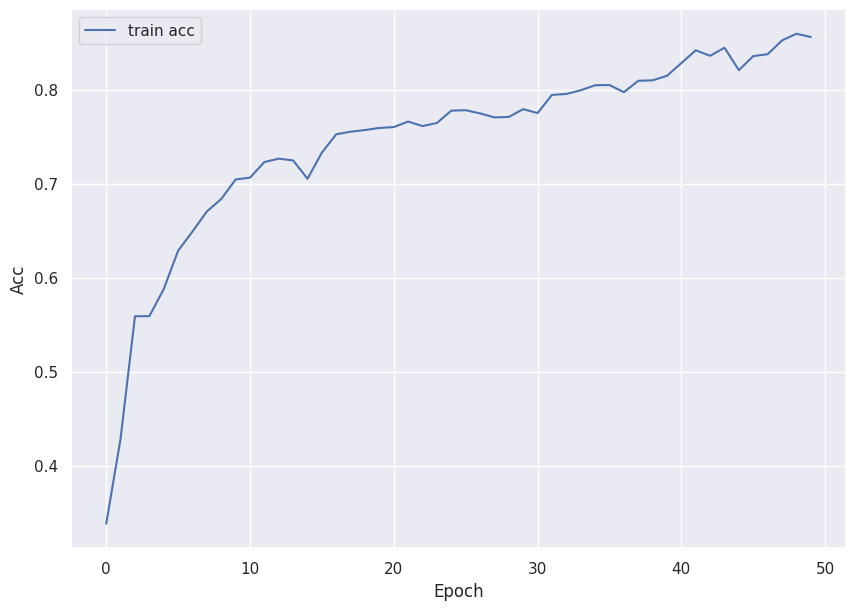

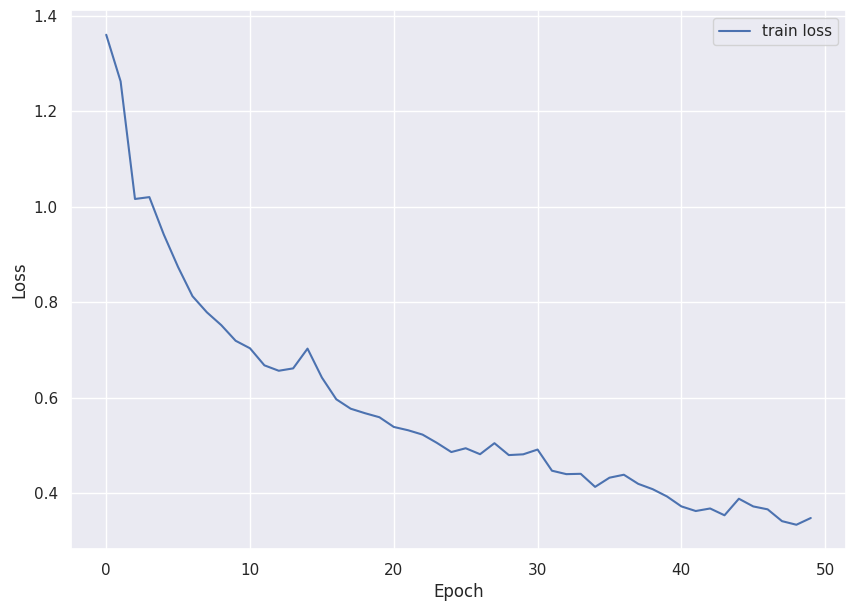

/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28287 (\N{CJK UNIFIED IDEOGRAPH-6E7F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 34164 (\N{CJK UNIFIED IDEOGRAPH-8574}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20860 (\N{CJK UNIFIE

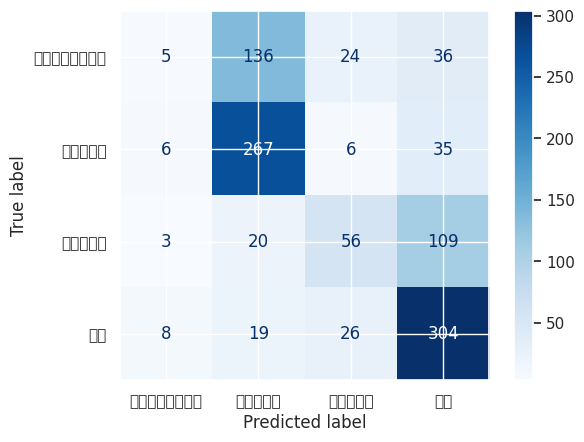

In [6]:
# -*- coding: utf-8 -*-
import numpy as np
import pickle as pkl
from tqdm import tqdm
from datetime import timedelta
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
import torch
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
from sklearn.metrics import precision_recall_fscore_support

# 超参数设置
data_path = './data0924.txt'              # 数据集
vocab_path = './vocab.pkl'                 # 词表
save_path = './lstm.ckpt'                   # 模型训练结果
embedding_pretrained = torch.tensor(
    np.load('./embedding_Tencent.npz')["embeddings"].astype('float32')
)  # 预训练词向量
embed = embedding_pretrained.size(1)        # 词向量维度
dropout = 0.5                               # 随机丢弃
num_classes = 4                             # 类别数
num_epochs = 50                            # epoch数
batch_size = 16                             # mini-batch大小
pad_size = 512                              # 每句话处理成的长度(短填长切)
learning_rate = 1e-3                        # 学习率
hidden_size = 128                           # lstm隐藏层
num_layers = 2                              # lstm层数
MAX_VOCAB_SIZE = 10000                      # 词表长度限制
UNK, PAD = '<UNK>', '<PAD>'                 # 未知字，padding符号

def get_data():
    tokenizer = lambda x: [y for y in x]  # 字级别
    vocab = pkl.load(open(vocab_path, 'rb'))
    print(f"Vocab size: {len(vocab)}")
    train, dev, test = load_dataset(data_path, pad_size, tokenizer, vocab)
    return vocab, train, dev, test

def load_dataset(path, pad_size, tokenizer, vocab):
    contents = []
    with open(path, 'r', encoding='gbk') as f:  # 确保编码正确
        for line in tqdm(f):
            lin = line.strip()
            if not lin:
                continue
            label, content = lin.split('	####	')
            words_line = []
            token = tokenizer(content)
            seq_len = len(token)
            if pad_size:
                if len(token) < pad_size:
                    token.extend([vocab.get(PAD)] * (pad_size - len(token)))
                else:
                    token = token[:pad_size]
                    seq_len = pad_size
            for word in token:
                words_line.append(vocab.get(word, vocab.get(UNK)))
            contents.append((words_line, int(label)))

    train, X_t = train_test_split(contents, test_size=0.4, random_state=42)
    dev, test = train_test_split(X_t, test_size=0.5, random_state=42)
    return train, dev, test

class TextDataset(Dataset):
    def __init__(self, data):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.x = torch.LongTensor([x[0] for x in data]).to(self.device)
        self.y = torch.LongTensor([x[1] for x in data]).to(self.device)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

def get_time_dif(start_time):
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_pretrained, freeze=False)
        self.lstm = nn.LSTM(embed, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out = self.embedding(x)
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        return out

def init_network(model, method='xavier', exclude='embedding'):
    for name, w in model.named_parameters():
        if exclude not in name:
            if 'weight' in name:
                nn.init.xavier_normal_(w)
            elif 'bias' in name:
                nn.init.constant_(w, 0)

def plot_acc(train_acc):
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 7))
    plt.plot(list(range(len(train_acc))), train_acc, label='train acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend(loc='best')
    plt.savefig('./acc.png', dpi=400)

def plot_loss(train_loss):
    sns.set(style='darkgrid')
    plt.figure(figsize=(10, 7))
    plt.plot(list(range(len(train_loss))), train_loss, label='train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.savefig('./loss.png', dpi=400)

def train(model, dataloaders):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    dev_best_loss = float('inf')
    
    plot_train_acc = []
    plot_train_loss = []
    
    for i in range(num_epochs):
        model.train()
        step = 0
        train_lossi = 0
        train_acci = 0
        
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            step += 1
            true = labels.data.cpu()
            predic = torch.max(outputs.data, 1)[1].cpu()
            train_lossi += loss.item()
            train_acci += metrics.accuracy_score(true, predic)
        
        dev_acc, dev_loss, dev_precision, dev_recall, dev_f1 = dev_eval(model, dataloaders['dev'], loss_function)

        if dev_loss < dev_best_loss:
            dev_best_loss = dev_loss
            torch.save(model.state_dict(), save_path)
        
        train_acc = train_acci / step
        train_loss = train_lossi / step
        plot_train_acc.append(train_acc)
        plot_train_loss.append(train_loss)
        
        print(f"Epoch {i+1}: Train Loss = {train_loss:.3f}, Train Acc = {train_acc:.2%}, "
              f"Val Loss = {dev_loss:.3f}, Val Acc = {dev_acc:.2%}, "
              f"Val Precision = {dev_precision:.4f}, Val Recall = {dev_recall:.4f}, Val F1 = {dev_f1:.4f}")

    plot_acc(plot_train_acc)
    plot_loss(plot_train_loss)
    
    model.load_state_dict(torch.load(save_path))
    model.eval()
    test_acc, test_loss, _, _, _ = dev_eval(model, dataloaders['test'], loss_function, Result_test=True)
    print('=================' * 8)
    print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2%}')

def dev_eval(model, data, loss_function, Result_test=False):
    model.eval()
    loss_total = 0
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)

    with torch.no_grad():
        for texts, labels in data:
            outputs = model(texts)
            loss = loss_function(outputs, labels)
            loss_total += loss.item()
            labels = labels.data.cpu().numpy()
            predic = torch.max(outputs.data, 1)[1].cpu().numpy()
            labels_all = np.append(labels_all, labels)
            predict_all = np.append(predict_all, predic)

    acc = metrics.accuracy_score(labels_all, predict_all)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_all, predict_all, average='micro')

    if Result_test:
        result_test(labels_all, predict_all)
    
    return acc, loss_total / len(data), precision, recall, f1

def result_test(real, pred):
    cv_conf = confusion_matrix(real, pred)
    acc = accuracy_score(real, pred)
    precision = precision_score(real, pred, average='micro')
    recall = recall_score(real, pred, average='micro')
    f1 = f1_score(real, pred, average='micro')
    
    print(f'Test: Acc = {acc:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}')
    labels = ['湿热蕴结兼脾虚证', '湿热蕴结证', '脾虚气滞证', '其他']
    disp = ConfusionMatrixDisplay(confusion_matrix=cv_conf, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.savefig('./confusion_matrix.png', dpi=400)

# 保存模型参数到字典文件
def save_model_params(model, filename):
    model_params = {name: param.detach().cpu().numpy() for name, param in model.named_parameters()}
    with open(filename, 'wb') as f:
        pkl.dump(model_params, f)
    print(f'Model parameters saved to {filename}')

if __name__ == '__main__':
    start_time = time.time()
    vocab, train_data, dev_data, test_data = get_data()
    train_data = TextDataset(train_data)
    dev_data = TextDataset(dev_data)
    test_data = TextDataset(test_data)

    dataloaders = {
        'train': DataLoader(train_data, batch_size=batch_size, shuffle=True),
        'dev': DataLoader(dev_data, batch_size=batch_size),
        'test': DataLoader(test_data, batch_size=batch_size),
    }
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = Model().to(device)
    init_network(model)

    train(model, dataloaders)

    # 保存模型参数
    save_model_params(model, 'model_params.pkl')

    end_time = get_time_dif(start_time)
    print("Training complete! Time taken:", end_time)


In [7]:
# -*- coding: utf-8 -*-
import numpy as np
import pickle as pkl
from tqdm import tqdm
from datetime import timedelta
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
import torch
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             precision_score, accuracy_score, f1_score,
                             recall_score, precision_recall_fscore_support)

# 超参数设置
data_path = './data0924.txt'              # 数据集
vocab_path = './vocab.pkl'                 # 词表
save_path = './lstm.ckpt'                   # 模型训练结果
embedding_pretrained = torch.tensor(
    np.load('./embedding_Tencent.npz')["embeddings"].astype('float32')
)  # 预训练词向量
embed = embedding_pretrained.size(1)        # 词向量维度
dropout = 0.5                               # 随机丢弃
num_classes = 4                             # 类别数
num_epochs = 50                             # epoch数
batch_size = 16                             # mini-batch大小
pad_size = 512                              # 每句话处理成的长度(短填长切)
learning_rate = 1e-3                        # 学习率
hidden_size = 128                           # lstm隐藏层
num_layers = 2                              # lstm层数
MAX_VOCAB_SIZE = 10000                      # 词表长度限制
UNK, PAD = '<UNK>', '<PAD>'                 # 未知字，padding符号

def get_data():
    tokenizer = lambda x: [y for y in x]  # 字级别
    vocab = pkl.load(open(vocab_path, 'rb'))
    print(f"Vocab size: {len(vocab)}")
    train, dev, test = load_dataset(data_path, pad_size, tokenizer, vocab)
    return vocab, train, dev, test

def load_dataset(path, pad_size, tokenizer, vocab):
    contents = []
    with open(path, 'r', encoding='gbk') as f:  # 确保编码正确
        for line in tqdm(f):
            lin = line.strip()
            if not lin:
                continue
            label, content = lin.split('	####	')
            words_line = []
            token = tokenizer(content)
            seq_len = len(token)
            if pad_size:
                if len(token) < pad_size:
                    token.extend([vocab.get(PAD)] * (pad_size - len(token)))
                else:
                    token = token[:pad_size]
                    seq_len = pad_size
            for word in token:
                words_line.append(vocab.get(word, vocab.get(UNK)))
            contents.append((words_line, int(label)))

    train, X_t = train_test_split(contents, test_size=0.4, random_state=42)
    dev, test = train_test_split(X_t, test_size=0.5, random_state=42)
    return train, dev, test

class TextDataset(Dataset):
    def __init__(self, data):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.x = torch.LongTensor([x[0] for x in data]).to(self.device)
        self.y = torch.LongTensor([x[1] for x in data]).to(self.device)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

def get_time_dif(start_time):
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_pretrained, freeze=False)
        self.lstm = nn.LSTM(embed, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out = self.embedding(x)
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        return out

def init_network(model, method='xavier', exclude='embedding'):
    for name, w in model.named_parameters():
        if exclude not in name:
            if 'weight' in name:
                nn.init.xavier_normal_(w)
            elif 'bias' in name:
                nn.init.constant_(w, 0)

def plot_metrics(results_df):
    sns.set(style='darkgrid')
    plt.figure(figsize=(12, 10))

    plt.subplot(3, 2, 1)
    plt.plot(results_df['Epoch'], results_df['Train Loss'], label='Train Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(results_df['Epoch'], results_df['Val Loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(results_df['Epoch'], results_df['Train Acc'], label='Train Acc', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train Accuracy')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(results_df['Epoch'], results_df['Val Acc'], label='Validation Acc', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(results_df['Epoch'], results_df['Val Precision'], label='Validation Precision', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Validation Precision')
    plt.legend()

    plt.subplot(3, 2, 6)
    plt.plot(results_df['Epoch'], results_df['Val Recall'], label='Validation Recall', color='brown')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Validation Recall')
    plt.legend()

    plt.tight_layout()
    plt.savefig('./training_metrics.pdf', dpi=400)
    plt.close()

def train(model, dataloaders):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    dev_best_loss = float('inf')
    
    results = []

    for i in range(num_epochs):
        model.train()
        step = 0
        train_lossi = 0
        train_acci = 0
        
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            step += 1
            true = labels.data.cpu()
            predic = torch.max(outputs.data, 1)[1].cpu()
            train_lossi += loss.item()
            train_acci += metrics.accuracy_score(true, predic)
        
        dev_acc, dev_loss, dev_precision, dev_recall, dev_f1 = dev_eval(model, dataloaders['dev'], loss_function)

        if dev_loss < dev_best_loss:
            dev_best_loss = dev_loss
            torch.save(model.state_dict(), save_path)
        
        train_acc = train_acci / step
        train_loss = train_lossi / step

        results.append({
            'Epoch': i + 1,
            'Train Loss': train_loss,
            'Train Acc': train_acc,
            'Val Loss': dev_loss,
            'Val Acc': dev_acc,
            'Val Precision': dev_precision,
            'Val Recall': dev_recall,
            'Val F1': dev_f1
        })
        
        print(f"Epoch {i+1}: Train Loss = {train_loss:.3f}, Train Acc = {train_acc:.2%}, "
              f"Val Loss = {dev_loss:.3f}, Val Acc = {dev_acc:.2%}, "
              f"Val Precision = {dev_precision:.4f}, Val Recall = {dev_recall:.4f}, Val F1 = {dev_f1:.4f}")

    # 保存结果到 CSV 文件
    results_df = pd.DataFrame(results)
    results_df.to_csv('./training_results.csv', index=False)
    
    plot_metrics(results_df)

def dev_eval(model, data, loss_function):
    model.eval()
    loss_total = 0
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)

    with torch.no_grad():
        for texts, labels in data:
            outputs = model(texts)
            loss = loss_function(outputs, labels)
            loss_total += loss.item()
            labels = labels.data.cpu().numpy()
            predic = torch.max(outputs.data, 1)[1].cpu().numpy()
            labels_all = np.append(labels_all, labels)
            predict_all = np.append(predict_all, predic)

    acc = metrics.accuracy_score(labels_all, predict_all)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_all, predict_all, average='micro')

    return acc, loss_total / len(data), precision, recall, f1

def result_test(real, pred):
    cv_conf = confusion_matrix(real, pred)
    acc = accuracy_score(real, pred)
    precision = precision_score(real, pred, average='micro')
    recall = recall_score(real, pred, average='micro')
    f1 = f1_score(real, pred, average='micro')
    
    print(f'Test: Acc = {acc:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}')
    labels = ['湿热蕴结兼脾虚证', '湿热蕴结证', '脾虚气滞证', '其他']
    disp = ConfusionMatrixDisplay(confusion_matrix=cv_conf, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.savefig('./confusion_matrix.png', dpi=400)

def save_model_params(model, filename):
    model_params = {name: param.detach().cpu().numpy() for name, param in model.named_parameters()}
    with open(filename, 'wb') as f:
        pkl.dump(model_params, f)
    print(f'Model parameters saved to {filename}')

if __name__ == '__main__':
    start_time = time.time()
    vocab, train_data, dev_data, test_data = get_data()
    train_data = TextDataset(train_data)
    dev_data = TextDataset(dev_data)
    test_data = TextDataset(test_data)

    dataloaders = {
        'train': DataLoader(train_data, batch_size=batch_size, shuffle=True),
        'dev': DataLoader(dev_data, batch_size=batch_size),
        'test': DataLoader(test_data, batch_size=batch_size),
    }
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = Model().to(device)
    init_network(model)

    train(model, dataloaders)

    # 保存模型参数
    save_model_params(model, 'model_params.pkl')

    end_time = get_time_dif(start_time)
    print("Training complete! Time taken:", end_time)


Vocab size: 4762


5300it [00:00, 10561.33it/s]


Epoch 1: Train Loss = 1.357, Train Acc = 33.85%, Val Loss = 1.351, Val Acc = 32.36%, Val Precision = 0.3236, Val Recall = 0.3236, Val F1 = 0.3236
Epoch 2: Train Loss = 1.348, Train Acc = 35.34%, Val Loss = 1.351, Val Acc = 34.62%, Val Precision = 0.3462, Val Recall = 0.3462, Val F1 = 0.3462
Epoch 3: Train Loss = 1.125, Train Acc = 51.57%, Val Loss = 1.046, Val Acc = 54.06%, Val Precision = 0.5406, Val Recall = 0.5406, Val F1 = 0.5406
Epoch 4: Train Loss = 0.998, Train Acc = 58.11%, Val Loss = 1.039, Val Acc = 54.15%, Val Precision = 0.5415, Val Recall = 0.5415, Val F1 = 0.5415
Epoch 5: Train Loss = 0.931, Train Acc = 60.44%, Val Loss = 0.993, Val Acc = 56.60%, Val Precision = 0.5660, Val Recall = 0.5660, Val F1 = 0.5660
Epoch 6: Train Loss = 0.860, Train Acc = 62.80%, Val Loss = 1.004, Val Acc = 58.49%, Val Precision = 0.5849, Val Recall = 0.5849, Val F1 = 0.5849
Epoch 7: Train Loss = 0.816, Train Acc = 65.48%, Val Loss = 1.030, Val Acc = 57.83%, Val Precision = 0.5783, Val Recall = 0.